In [ ]:
#what to do for this code?

#Make an NCA model with the conv MLP architecture
#Train it to do the white square
# Consider that it needs extra dimensions for data like how large the square is

#Try training it

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from diffevo import DDIMSchedulerCosine, BayesianGenerator
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [298]:
class NCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCA, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # 1x1 convolution
        self.conv2 = nn.Conv2d(16, 16, kernel_size=1)           # 1x1 convolution
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=1) # 1x1 convolution

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.sigmoid(x)
        return x
    
    def infer(self, x, steps):
        for i in range(steps):
            x = self.forward(x)
        return x
    
    def getInput(self, size):
        contextVector = torch.zeros((1, 1, size, size))
        noise = torch.randn_like(contextVector)
        
        return torch.cat([noise, contextVector], dim=1)

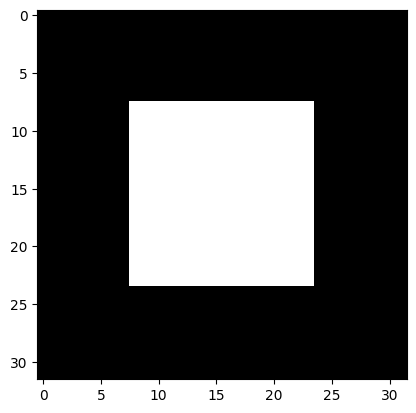

In [238]:
image_size = 32 # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, image_size, image_size))
image[0, 8:24, 8:24] = 1.0

plt.imshow(image[0].cpu().numpy(), cmap='gray')

In [299]:
model = NCA(2, 2)
torch.set_grad_enabled(False)

torch.Size([1, 2, 32, 32])


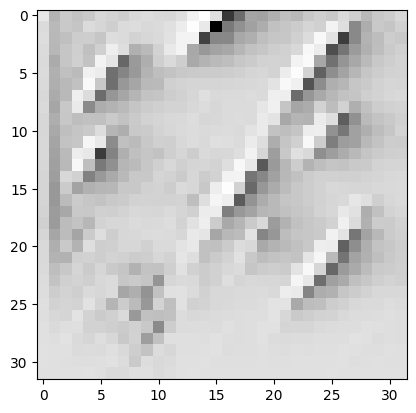

In [ ]:
##DON'T RUN
# Infermodel

steps = 20
contextVector = torch.zeros((1, 1, image_size, image_size))
noise = torch.randn_like(contextVector)

x = torch.cat([noise, contextVector], dim=1)

print(x.shape)

for i in range(steps):
    x = model(x)

plt.imshow(x[0, 0].cpu().numpy(), cmap='gray')
plt.show()

In [240]:
def set_model_params(model, x):
    idx = 0
    for param in model.parameters():
        num_elements = param.numel()  # Number of elements in this parameter
        param.copy_(x[idx : idx + num_elements].view(param.shape))  # Reshape & assign
        idx += num_elements

def get_model_params(model):
    """Returns the flattened parameters of a model."""
    params = []
    for param in model.parameters():
        params.append(param.view(-1))  # Flatten each parameter tensor
    return torch.cat(params)  # Concatenate all parameters into a single vector

In [364]:
population = 16

#modelParams = torch.randn(population, totalParams)
models = [NCA(2, 2) for _ in range(population)]
#Using defualt NCA as initial values
modelParams = torch.stack([get_model_params(model) for model in models])

In [371]:
scheduler = DDIMSchedulerCosine(num_step=101)

def evaluateModels(modelParams):
    #Set models
    for i, model in enumerate(models): 
        set_model_params(model, modelParams[i])

    #Evaluate models
    fitness = torch.zeros(population)
    for i, model in enumerate(models):
        modelInput = model.getInput(image_size)
        modelOutput = model.infer(modelInput, 20)

        #fitness[i] = F.mse_loss(modelOutput[0, 0], image[0])
        fitness[i] = -torch.log10(F.mse_loss(modelOutput[0, 0], image[0])  + 1e-8)
        
    return fitness


for t, alpha in scheduler:
    fitness = evaluateModels(modelParams)
    generator = BayesianGenerator(modelParams, fitness, alpha)
    modelParams = generator(noise=0.5)
    if t % 10 == 0:
        print(f"step {t}, max was {fitness.max()}, index {fitness.argmax()}")
    if torch.isnan(modelParams).any():
        break

step 100, max was 0.602166473865509, index 15
step 90, max was 0.6045171022415161, index 15
step 80, max was 0.6020912528038025, index 3
step 70, max was 0.6021701693534851, index 9
step 60, max was 0.602486789226532, index 11
step 50, max was 0.6020619869232178, index 13
step 40, max was 0.6052641868591309, index 11
step 30, max was 0.6022171974182129, index 4
step 20, max was 0.6022627353668213, index 14
step 10, max was 0.6179628372192383, index 14


In [235]:
generator.fitness

tensor([-1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12,
        -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12,         nan,
        -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12,
        -1.0000e+12])

In [345]:
def inferModels():
    #Evaluate models
    output = torch.zeros((16, image_size, image_size))
    for i, model in enumerate(models):
        modelInput = model.getInput(image_size)
        output[i] = model.infer(modelInput, 20)[0,0]

    return output

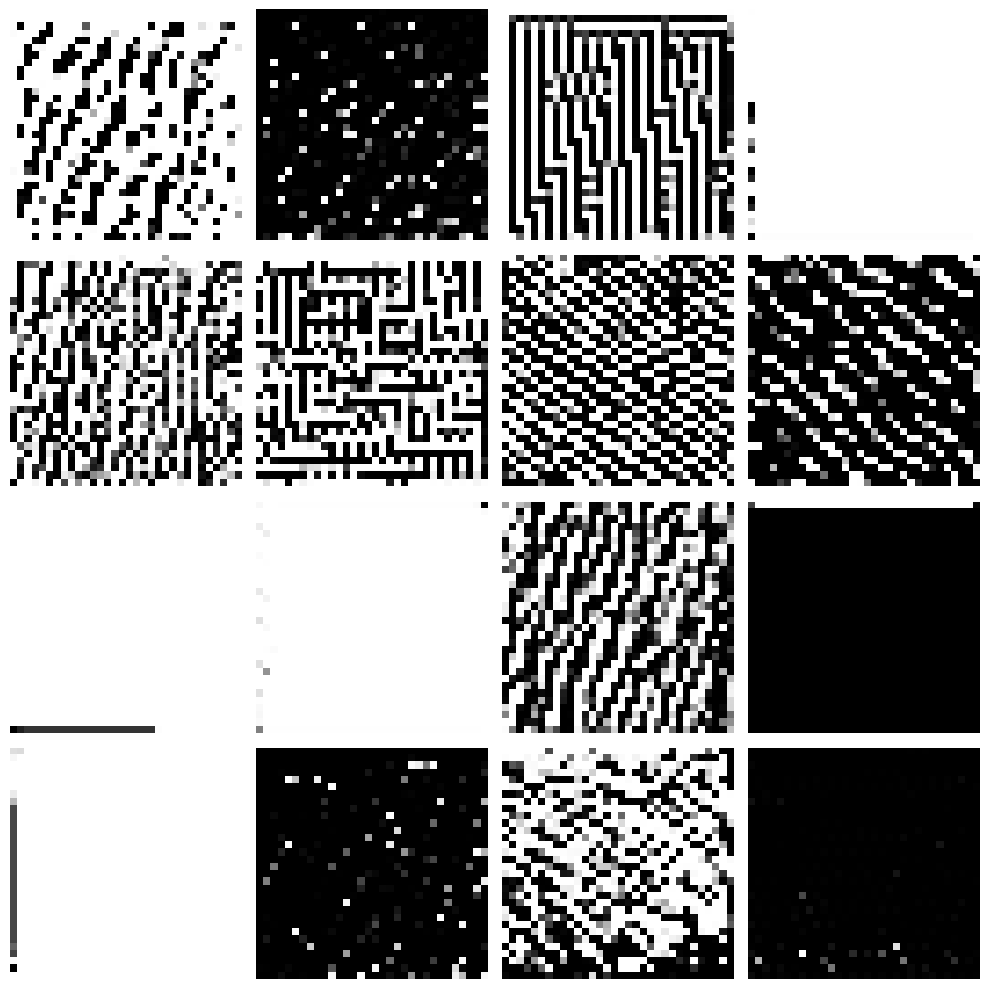

In [369]:
outs = inferModels()
def displayImages(images): #displays 16 images in a 4x4 grid
    num_images = images.shape[0]
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  
    axes = axes.flatten() 
    
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy(), cmap='gray')
        ax.axis('off')  
    
    plt.tight_layout()
    plt.show()

displayImages(outs)

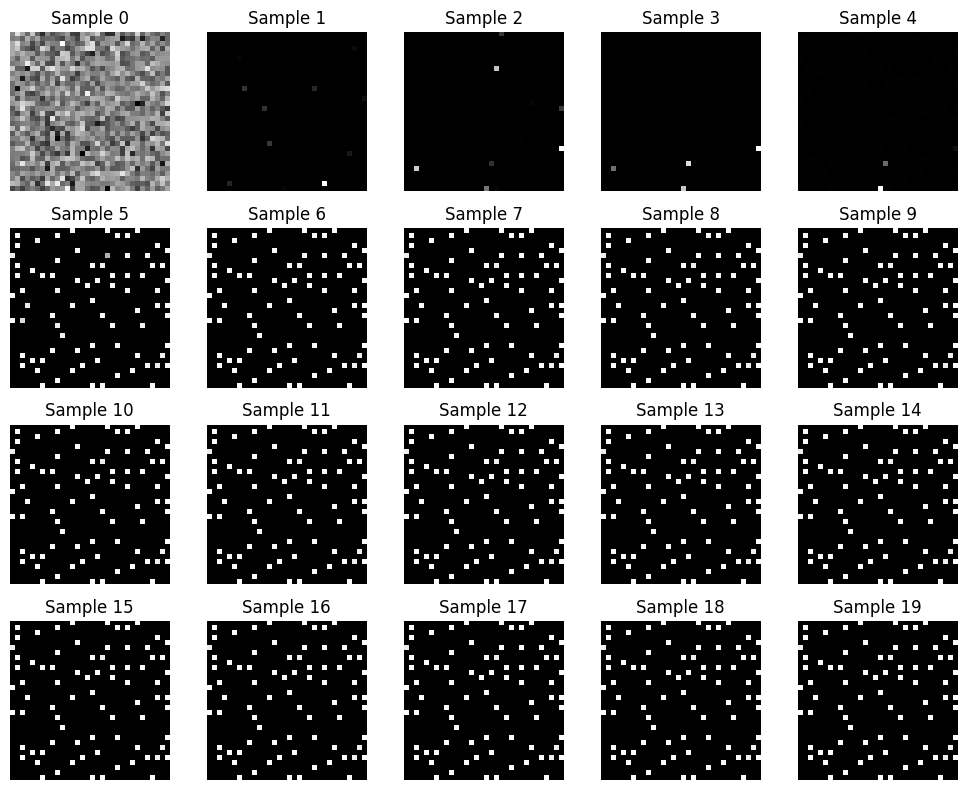

In [372]:
output = torch.zeros((20, 2, image_size, image_size))
modelInput = models[0].getInput(image_size)
output[0] = modelInput

for i in range(19):
    output[i + 1] = models[0].forward(output[i])

#Visualize the output
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  # 4x5 grid for 20 images
axes = axes.flatten()

for i in range(20):
    axes[i].imshow(output[i, 0].cpu().numpy(), cmap='gray')
    axes[i].axis('off')  # Hide axes for cleaner display
    axes[i].set_title(f"Sample {i}")

plt.tight_layout()
plt.show()
